In [3]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms

import random
import numpy as np

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# Data

In [4]:
transform = transforms.ToTensor()

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 231kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.30MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.1MB/s]


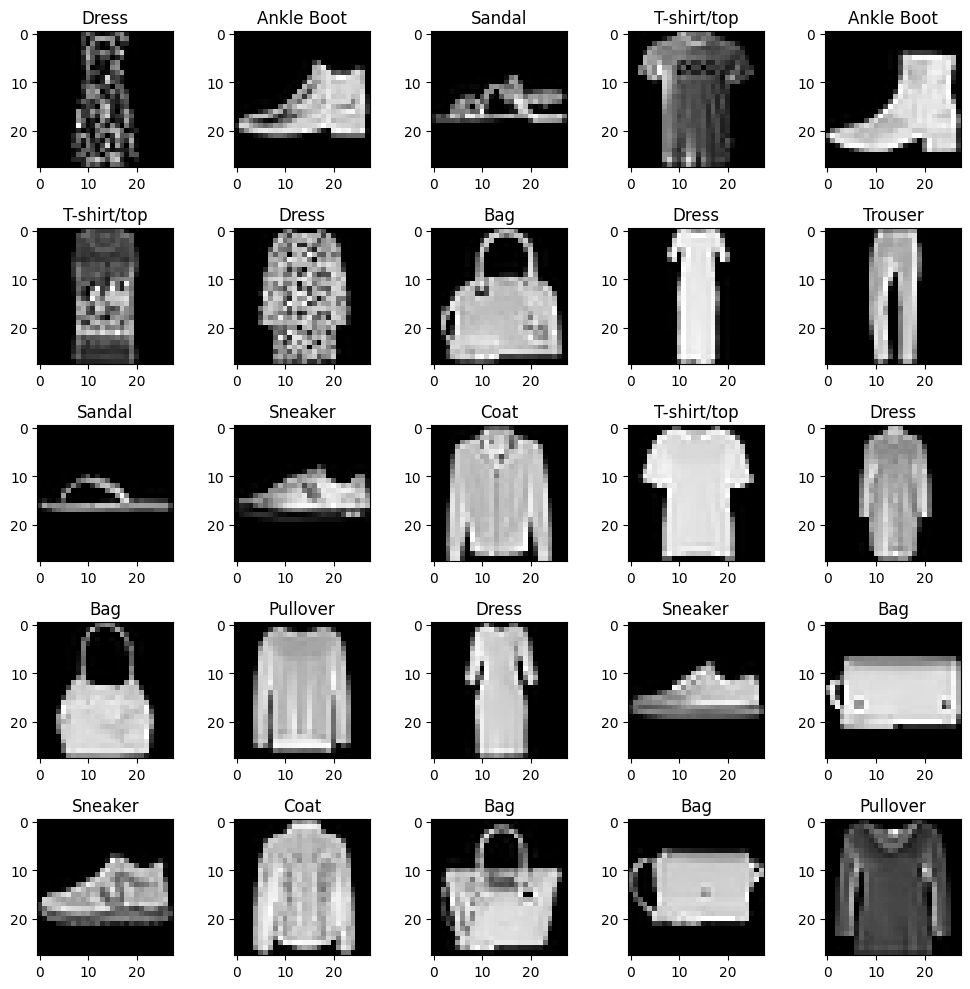

In [5]:
batch = next(iter(training_loader))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(*batch)):
    if i > 24:
        break
    plt.subplot(5, 5, i + 1)
    plt.imshow(image[0], cmap="gray")
    plt.title(classes[label])

plt.tight_layout()

# Exercise

You are required to train an MLP on the Fashion MNIST dataset. For this task, you must define the following:

* The objective function
* The model architecture
* The optimizer
* The training loop

You will train three MLP models, each with different hyperparameters. You must vary at least two of the following aspects between the models:

* Number of layers
* Number of neurons
* Activation function
* Optimizer


## Deliverables
* The complete code
* Learning curves for the three MLP models
* Table summarizing the changes in the hyperparameters and the performance of the models on the train and test sets.
* A write-up analyzing how your choices impacted the results.

## **Model Architecture**

In [6]:
class SimpleNN(nn.Module):

  def __init__(self, input_size, n_class, n_layers, hidden_units, activation) -> None:

     super().__init__()

     self.n_class = n_class
     self.n_layers = n_layers
     self.hidden_units = hidden_units

     self.flatten = nn.Flatten(start_dim=1)          # Define the flattening layer

     self.hidden_layers = nn.ModuleList([nn.Linear(self.hidden_units, self.hidden_units) if layer != 0 else nn.Linear(input_size, self.hidden_units) for layer in range(n_layers)])
     self.output_layer = nn.Linear(self.hidden_units, n_class)
     self.activation = activation

     if activation == 'relu':
        self.activation = nn.ReLU()
     elif activation == 'leakyRelu':
        self.activation = nn.LeakyReLU()
     elif activation == 'tanh':
        self.activation = nn.Tanh()
     elif activation == 'sigmoid':
        self.activation = nn.Sigmoid()
     else:
        raise ValueError("Invalid activation function. Choose from ['relu', 'leakyRelu', 'tanh', 'sigmoid'].")


  def forward(self, x):

    #print('ORIGINAL X_shapeeeeeee:', x.shape)
    x = self.flatten(x)            # Reshape from (batch, 1, 28, 28) -> (batch, 784)
    #print('Flattened X_shapeeeeeee:', x.shape)

    for idx, layer in enumerate(self.hidden_layers):
        x = layer(x)            # Pass the input to the neural network
        x = self.activation(x)                      # Apply some non-linearity
        #print(f'Layer {idx+1}:', x.shape)

    output = self.output_layer(x)
    #print('OUTPUT LAYER X_shapeeeeeee:', x.shape)

    return output

## **Define the Device**

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **Objective Function**

In [8]:
criterion = nn.CrossEntropyLoss()           # Since we are dealing with a multi-class classification problem, we will choose cross entropy

## **Training Function**

In [9]:
def train_model(model, criterion, device, train_dataloader, lr, n_epochs):

  model.to(device)      # Move model to device
  model.train()         # Set the model to training phase

  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)  # Define the optimizer
  epoch_losses = []


  # Train the model for a number of epochs
  for epoch in range(n_epochs):

    # Reset the epoch loss at the beginning of each epoch
    epoch_loss = 0.0
    total_samples = 0

    # Iterate through each batch of data and perform forward & backward pass
    for images, labels in train_dataloader:

      images, labels = images.to(device), labels.to(device)       # Move images and labels to device
      #print('Images SHAPEEE:', images.shape)
      #print('Labels SHAPEEE:', labels.shape)

      # Forward Pass
      output = model(images)
      loss = criterion(output, labels)      # Compute loss

      batch_size = labels.size(0)                   # Get size of current batch
      total_samples += batch_size                   # Accumulate number of samples used in each epoch
      epoch_loss += loss.item() * batch_size        # Accumulate loss for each epoch


      # Backward pass
      loss.backward()         # Perform backpropagation
      optimizer.step()        # Update the weights (model parameters)
      optimizer.zero_grad()   # Zero the gradients to avoid accumulation between batches of data

    epoch_losses.append(epoch_loss/ total_samples)       # Store the average training loss for the recently finished epoch
    print(f'Epoch {epoch+1}/{n_epochs} finished with loss of {epoch_loss / total_samples}')


  return epoch_losses

## **Validation Function**

In [10]:
def evaluate_model(model, criterion, device, val_loader):

  model.to(device)    # Move Model to Device
  model.eval()        # Set the model to the evaluation mode
  val_loss = 0.0      # Initialize the validation losss
  correct, total = 0, 0

  # No gradient tracking (prevents backtracking)
  with torch.no_grad():

    for images, labels in val_loader:

      images, labels = images.to(device), labels.to(device)
      output = model(images)

      # Get size of current batch
      batch_size = labels.size(0)

      # Compute loss
      loss = criterion(output, labels)
      val_loss += loss.item()

      # Compute the accuracy
      _, predicted = torch.max(output, 1)             # Get class with highest probability
      correct += (predicted == labels).sum().item()
      total += batch_size

  val_loss /= total        # Average the validation loss
  val_accuracy = 100 * (correct / total)      # Get validation accuracy

  print('Validation Loss:', val_loss)
  print(f'Validation Accuracy: {val_accuracy} %')

  return val_loss, val_accuracy

## **Loss Plotting Function**

In [11]:
def plot_loss(train_losses):

  n_epochs = len(train_losses)

  plt.figure(figsize=(6, 4))
  plt.grid(True, linestyle='--', alpha=0.6)

  plt.plot(range(1, n_epochs + 1), train_losses, marker='o', linestyle='-', color='b', label='Training Loss')

  plt.title('Training Loss Across Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Training Loss')

  plt.xticks(range(1, n_epochs + 1, max(1, n_epochs // 10)))

  plt.legend()
  plt.show()

## **Some Useful Variables**

In [12]:
n_classes = len(classes)
batch = next(iter(training_loader))         # Select a random batch
images, labels = batch[0], batch[1]
image_shape = torch.prod(torch.tensor(images[0].size())).item()
print('Shape of each Flattened Image is:', image_shape)

Shape of each Flattened Image is: 784


## **First Model** (Shallow/Moderate Neural Network with larger number of neurons)

### **1- First Hyperparameters Combination (lr = 0.01, number of epochs = 10)**

In [11]:
model_1 = SimpleNN(input_size=image_shape, n_class=n_classes, n_layers=4, hidden_units=10, activation='relu')
epoch_losses = train_model(model_1, criterion, device, train_dataloader=training_loader, lr=0.01, n_epochs=10)

Epoch 1/10 finished with loss of 0.6665482893784841
Epoch 2/10 finished with loss of 0.5294541245301565
Epoch 3/10 finished with loss of 0.5148084382931392
Epoch 4/10 finished with loss of 0.49761637058258057
Epoch 5/10 finished with loss of 0.48986986786524456
Epoch 6/10 finished with loss of 0.4914817947745323
Epoch 7/10 finished with loss of 0.4895696920235952
Epoch 8/10 finished with loss of 0.4864086573004723
Epoch 9/10 finished with loss of 0.481538395913442
Epoch 10/10 finished with loss of 0.4857334362387657


Validation Loss: 0.0042844989746809005
Validation Accuracy: 81.6 %


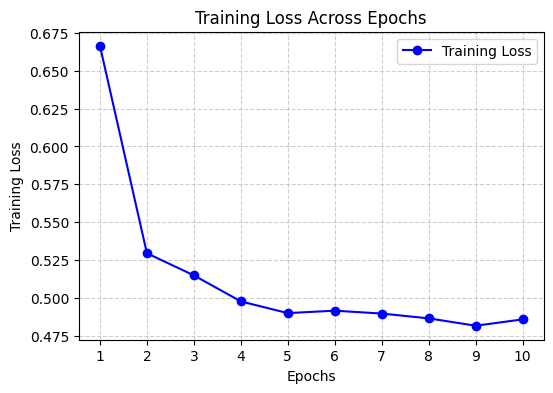

In [12]:
val_loss, val_acc = evaluate_model(model_1, criterion, device, validation_loader)
plot_loss(epoch_losses)

### **2- Second Hyperparameters Combination (lr = 0.001, number of epochs = 20)**

In [13]:
model_1 = SimpleNN(input_size=image_shape, n_class=n_classes, n_layers=4, hidden_units=10, activation='relu')
epoch_losses = train_model(model_1, criterion, device, train_dataloader=training_loader, lr=0.001, n_epochs=20)

Epoch 1/20 finished with loss of 0.8187735576629639
Epoch 2/20 finished with loss of 0.5321719191392262
Epoch 3/20 finished with loss of 0.4888328997055689
Epoch 4/20 finished with loss of 0.46052059801419576
Epoch 5/20 finished with loss of 0.4410747477889061
Epoch 6/20 finished with loss of 0.42798380332787833
Epoch 7/20 finished with loss of 0.41666266382137934
Epoch 8/20 finished with loss of 0.4060208522637685
Epoch 9/20 finished with loss of 0.3983526855071386
Epoch 10/20 finished with loss of 0.3924694448550542
Epoch 11/20 finished with loss of 0.3869929653565089
Epoch 12/20 finished with loss of 0.3822898549199104
Epoch 13/20 finished with loss of 0.37748254965941114
Epoch 14/20 finished with loss of 0.37294874665737154
Epoch 15/20 finished with loss of 0.3680846329450607
Epoch 16/20 finished with loss of 0.364241803731521
Epoch 17/20 finished with loss of 0.36231042118469875
Epoch 18/20 finished with loss of 0.3585711468795935
Epoch 19/20 finished with loss of 0.35711763122479

Validation Loss: 0.0034458933874964713
Validation Accuracy: 84.39 %


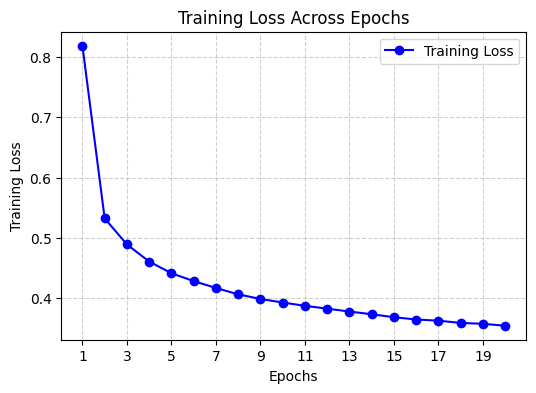

In [14]:
val_loss, val_acc = evaluate_model(model_1, criterion, device, validation_loader)
plot_loss(epoch_losses)

### **3- Third Hyperparameters Combination (lr = 0.001, number of epochs = 30)**

In [15]:
model_1 = SimpleNN(input_size=image_shape, n_class=n_classes, n_layers=4, hidden_units=10, activation='relu')
epoch_losses = train_model(model_1, criterion, device, train_dataloader=training_loader, lr=0.001, n_epochs=30)

Epoch 1/30 finished with loss of 0.900518641893069
Epoch 2/30 finished with loss of 0.5703080210924149
Epoch 3/30 finished with loss of 0.5234515300035477
Epoch 4/30 finished with loss of 0.49775822159449257
Epoch 5/30 finished with loss of 0.4770417999863625
Epoch 6/30 finished with loss of 0.45902154753605523
Epoch 7/30 finished with loss of 0.44797660347620644
Epoch 8/30 finished with loss of 0.438093180334568
Epoch 9/30 finished with loss of 0.43135955877701443
Epoch 10/30 finished with loss of 0.424103114938736
Epoch 11/30 finished with loss of 0.41787494258880614
Epoch 12/30 finished with loss of 0.4120000288228194
Epoch 13/30 finished with loss of 0.40811056108872096
Epoch 14/30 finished with loss of 0.4038744712948799
Epoch 15/30 finished with loss of 0.39801733450889587
Epoch 16/30 finished with loss of 0.3948331076780955
Epoch 17/30 finished with loss of 0.39084666254520417
Epoch 18/30 finished with loss of 0.38676437592903773
Epoch 19/30 finished with loss of 0.3847518321871

Validation Loss: 0.003409274382889271
Validation Accuracy: 85.19 %


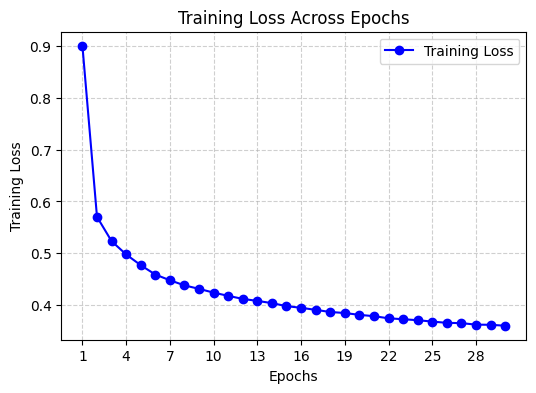

In [16]:
val_loss, val_acc = evaluate_model(model_1, criterion, device, validation_loader)
plot_loss(epoch_losses)

## **Second Model** (Shallow/Moderate Neural Network with smaller number of neurons)

### **1- First Hyperparameters Combination (lr = 0.01, number of epochs = 10)**

In [17]:
model_2 = SimpleNN(input_size=image_shape, n_class=n_classes, n_layers=4, hidden_units=5, activation='relu')
epoch_losses = train_model(model_2, criterion, device, train_dataloader=training_loader, lr=0.01, n_epochs=10)

Epoch 1/10 finished with loss of 0.8635922497272491
Epoch 2/10 finished with loss of 0.6650373138348261
Epoch 3/10 finished with loss of 0.6336306257565816
Epoch 4/10 finished with loss of 0.6201248434623082
Epoch 5/10 finished with loss of 0.6100334983507792
Epoch 6/10 finished with loss of 0.6064107348839441
Epoch 7/10 finished with loss of 0.6014422052542369
Epoch 8/10 finished with loss of 0.5986542291243871
Epoch 9/10 finished with loss of 0.5930239112695058
Epoch 10/10 finished with loss of 0.5946449120759963


Validation Loss: 0.0047748588562011715
Validation Accuracy: 79.01 %


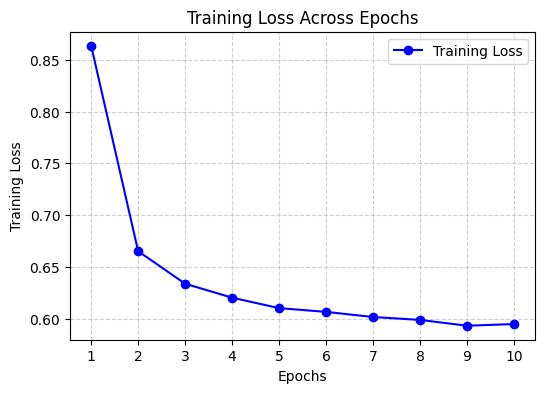

In [18]:
val_loss, val_acc = evaluate_model(model_2, criterion, device, validation_loader)
plot_loss(epoch_losses)

### **2- Second Hyperparameters Combination (lr = 0.001, number of epochs = 20)**

In [19]:
model_2 = SimpleNN(input_size=image_shape, n_class=n_classes, n_layers=4, hidden_units=5, activation='relu')
epoch_losses = train_model(model_2, criterion, device, train_dataloader=training_loader, lr=0.001, n_epochs=20)

Epoch 1/20 finished with loss of 1.3119184807777404
Epoch 2/20 finished with loss of 0.8575786798795064
Epoch 3/20 finished with loss of 0.7905390049775441
Epoch 4/20 finished with loss of 0.7473806964079539
Epoch 5/20 finished with loss of 0.7110413975556692
Epoch 6/20 finished with loss of 0.6826959419886272
Epoch 7/20 finished with loss of 0.6641231048504511
Epoch 8/20 finished with loss of 0.6506534717321396
Epoch 9/20 finished with loss of 0.6375761007070542
Epoch 10/20 finished with loss of 0.6292913733959198
Epoch 11/20 finished with loss of 0.6207801086028417
Epoch 12/20 finished with loss of 0.614065556804339
Epoch 13/20 finished with loss of 0.6084435933907827
Epoch 14/20 finished with loss of 0.6057615880012512
Epoch 15/20 finished with loss of 0.5992857084592184
Epoch 16/20 finished with loss of 0.5958190610647202
Epoch 17/20 finished with loss of 0.5918473807255427
Epoch 18/20 finished with loss of 0.5876008223930995
Epoch 19/20 finished with loss of 0.5835618398269018
Epo

Validation Loss: 0.004810637053847313
Validation Accuracy: 77.82 %


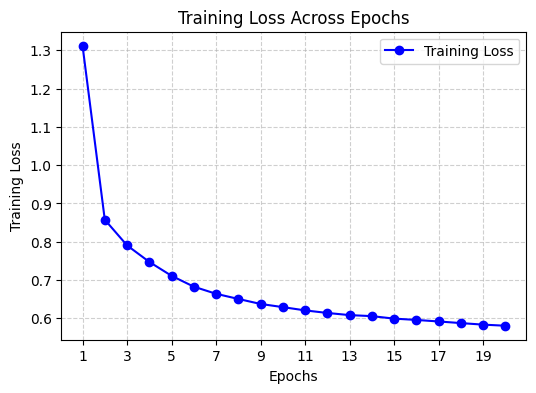

In [20]:
val_loss, val_acc = evaluate_model(model_2, criterion, device, validation_loader)
plot_loss(epoch_losses)

### **3- Third Hyperparameters Combination (lr = 0.001, number of epochs = 30)**

In [21]:
model_2 = SimpleNN(input_size=image_shape, n_class=n_classes, n_layers=4, hidden_units=5, activation='relu')
epoch_losses = train_model(model_2, criterion, device, train_dataloader=training_loader, lr=0.001, n_epochs=30)

Epoch 1/30 finished with loss of 1.3367934447924297
Epoch 2/30 finished with loss of 0.8618135851701101
Epoch 3/30 finished with loss of 0.8027718298276265
Epoch 4/30 finished with loss of 0.7677310548782349
Epoch 5/30 finished with loss of 0.736782154973348
Epoch 6/30 finished with loss of 0.7105724142551422
Epoch 7/30 finished with loss of 0.6930155014038086
Epoch 8/30 finished with loss of 0.6798617636124293
Epoch 9/30 finished with loss of 0.6668610009193421
Epoch 10/30 finished with loss of 0.6587876313289006
Epoch 11/30 finished with loss of 0.6518047832330068
Epoch 12/30 finished with loss of 0.6430566295782725
Epoch 13/30 finished with loss of 0.6396072797934215
Epoch 14/30 finished with loss of 0.6321746218999227
Epoch 15/30 finished with loss of 0.6304822999477386
Epoch 16/30 finished with loss of 0.6259073903481166
Epoch 17/30 finished with loss of 0.6196396487951279
Epoch 18/30 finished with loss of 0.6175189565896988
Epoch 19/30 finished with loss of 0.6149177236795426
Epo

Validation Loss: 0.005180642050504685
Validation Accuracy: 77.2 %


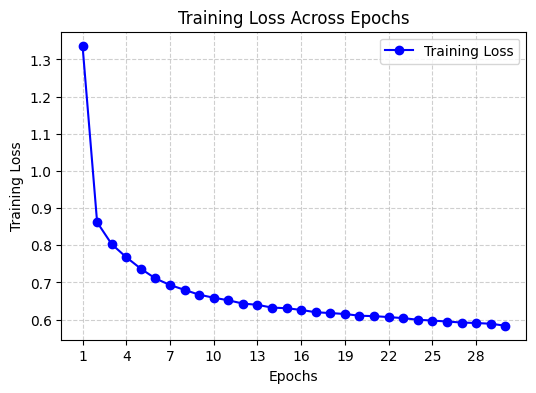

In [22]:
val_loss, val_acc = evaluate_model(model_2, criterion, device, validation_loader)
plot_loss(epoch_losses)

## **Third Model** (Deep Neural Network with smaller number of neurons)

### **1- First Hyperparameters Combination (lr = 0.01, number of epochs = 10)**

In [23]:
model_3 = SimpleNN(input_size=image_shape, n_class=n_classes, n_layers=10, hidden_units=5, activation='relu')
epoch_losses = train_model(model_3, criterion, device, train_dataloader=training_loader, lr=0.01, n_epochs=10)

Epoch 1/10 finished with loss of 1.3611495999972025
Epoch 2/10 finished with loss of 1.171273188304901
Epoch 3/10 finished with loss of 1.157008186817169
Epoch 4/10 finished with loss of 1.0971038181622823
Epoch 5/10 finished with loss of 0.9081175055821736
Epoch 6/10 finished with loss of 0.8779455495993296
Epoch 7/10 finished with loss of 0.8440142858346303
Epoch 8/10 finished with loss of 0.8291433424949646
Epoch 9/10 finished with loss of 0.8168454842567444
Epoch 10/10 finished with loss of 0.8236718362649282


Validation Loss: 0.00614312049150467
Validation Accuracy: 71.39 %


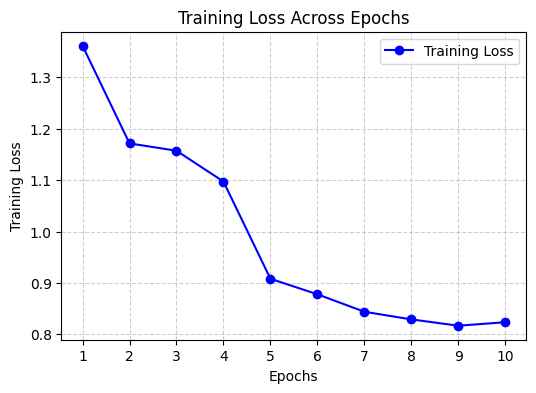

In [24]:
val_loss, val_acc = evaluate_model(model_3, criterion, device, validation_loader)
plot_loss(epoch_losses)

### **2- Second Hyperparameters Combination (lr = 0.001, number of epochs = 20)**

In [25]:
model_3 = SimpleNN(input_size=image_shape, n_class=n_classes, n_layers=10, hidden_units=5, activation='relu')
epoch_losses = train_model(model_3, criterion, device, train_dataloader=training_loader, lr=0.001, n_epochs=20)

Epoch 1/20 finished with loss of 2.305212400945028
Epoch 2/20 finished with loss of 2.3029082286834717
Epoch 3/20 finished with loss of 2.302894412612915
Epoch 4/20 finished with loss of 2.3028985502878827
Epoch 5/20 finished with loss of 2.3028751914978027
Epoch 6/20 finished with loss of 2.3029134803771973
Epoch 7/20 finished with loss of 2.3029259746551514
Epoch 8/20 finished with loss of 2.3028673408508302
Epoch 9/20 finished with loss of 2.302930155054728
Epoch 10/20 finished with loss of 2.302905650838216
Epoch 11/20 finished with loss of 2.302898313776652
Epoch 12/20 finished with loss of 2.302844575246175
Epoch 13/20 finished with loss of 2.302927381388346
Epoch 14/20 finished with loss of 2.3028672688802083
Epoch 15/20 finished with loss of 2.302839376831055
Epoch 16/20 finished with loss of 2.3028924518585203
Epoch 17/20 finished with loss of 2.3028493344624836
Epoch 18/20 finished with loss of 2.3028525698343913
Epoch 19/20 finished with loss of 2.3028700766245525
Epoch 20/2

Validation Loss: 0.018191742587089537
Validation Accuracy: 10.0 %


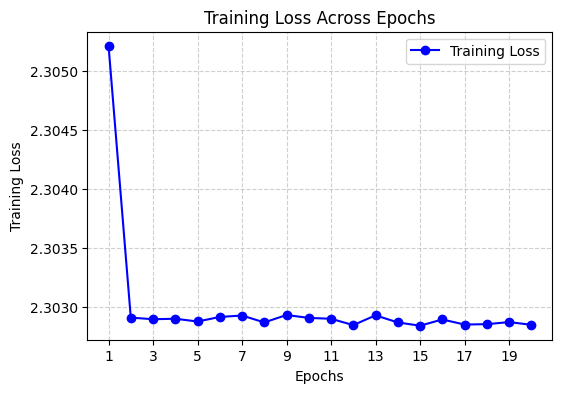

In [26]:
val_loss, val_acc = evaluate_model(model_3, criterion, device, validation_loader)
plot_loss(epoch_losses)

### **3- Third Hyperparameters Combination (lr = 0.001, number of epochs = 30)**

In [27]:
model_3 = SimpleNN(input_size=image_shape, n_class=n_classes, n_layers=10, hidden_units=5, activation='relu')
epoch_losses = train_model(model_3, criterion, device, train_dataloader=training_loader, lr=0.001, n_epochs=30)

Epoch 1/30 finished with loss of 1.617377981376648
Epoch 2/30 finished with loss of 1.0339458015759786
Epoch 3/30 finished with loss of 0.9474478259086608
Epoch 4/30 finished with loss of 0.8740609040578207
Epoch 5/30 finished with loss of 0.8216682896296184
Epoch 6/30 finished with loss of 0.7895189942995707
Epoch 7/30 finished with loss of 0.7706377624670665
Epoch 8/30 finished with loss of 0.7530221886316936
Epoch 9/30 finished with loss of 0.7426108417352041
Epoch 10/30 finished with loss of 0.728345424079895
Epoch 11/30 finished with loss of 0.7206218455155691
Epoch 12/30 finished with loss of 0.7083580673058828
Epoch 13/30 finished with loss of 0.6998704663674037
Epoch 14/30 finished with loss of 0.6951882764339447
Epoch 15/30 finished with loss of 0.689144677956899
Epoch 16/30 finished with loss of 0.6796375619252523
Epoch 17/30 finished with loss of 0.6747863403638203
Epoch 18/30 finished with loss of 0.6679614649772644
Epoch 19/30 finished with loss of 0.6613704139709473
Epoch

Validation Loss: 0.005326361238956452
Validation Accuracy: 78.53 %


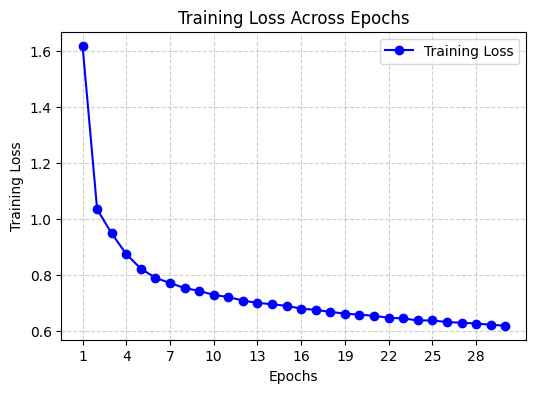

In [28]:
val_loss, val_acc = evaluate_model(model_3, criterion, device, validation_loader)
plot_loss(epoch_losses)

## **Fourth Model** (Deep Neural Network with larger number of neurons)

### **1- First Hyperparameters Combination (lr = 0.01, number of epochs = 10)**

In [29]:
model_4 = SimpleNN(input_size=image_shape, n_class=n_classes, n_layers=10, hidden_units=10, activation='relu')
epoch_losses = train_model(model_4, criterion, device, train_dataloader=training_loader, lr=0.01, n_epochs=10)

Epoch 1/10 finished with loss of 1.0974558761119844
Epoch 2/10 finished with loss of 1.2328202673276265
Epoch 3/10 finished with loss of 1.0013386880556743
Epoch 4/10 finished with loss of 0.9413528646628062
Epoch 5/10 finished with loss of 0.885764742120107
Epoch 6/10 finished with loss of 0.8459186255772908
Epoch 7/10 finished with loss of 0.8327724946339925
Epoch 8/10 finished with loss of 0.800409845050176
Epoch 9/10 finished with loss of 0.8229067696412404
Epoch 10/10 finished with loss of 1.0141097386201223


Validation Loss: 0.007222294080257416
Validation Accuracy: 63.1 %


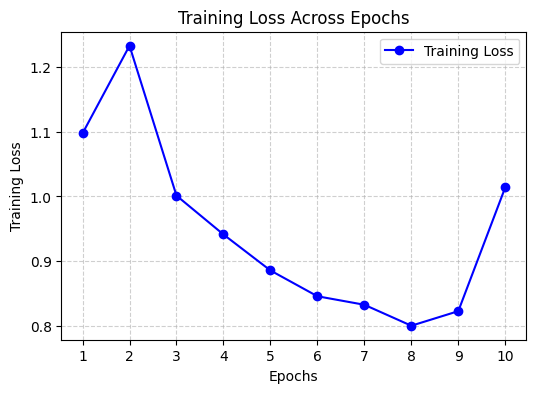

In [30]:
val_loss, val_acc = evaluate_model(model_4, criterion, device, validation_loader)
plot_loss(epoch_losses)

### **2- Second Hyperparameters Combination (lr = 0.001, number of epochs = 20)**

In [31]:
model_4 = SimpleNN(input_size=image_shape, n_class=n_classes, n_layers=10, hidden_units=10, activation='relu')
epoch_losses = train_model(model_4, criterion, device, train_dataloader=training_loader, lr=0.001, n_epochs=20)

Epoch 1/20 finished with loss of 1.096117739454905
Epoch 2/20 finished with loss of 0.8106492345809937
Epoch 3/20 finished with loss of 0.7447186981836955
Epoch 4/20 finished with loss of 0.7051185222148896
Epoch 5/20 finished with loss of 0.6706528032859167
Epoch 6/20 finished with loss of 0.6342382320483526
Epoch 7/20 finished with loss of 0.6027815495411555
Epoch 8/20 finished with loss of 0.5836227514664332
Epoch 9/20 finished with loss of 0.5678587679942448
Epoch 10/20 finished with loss of 0.5549428649425506
Epoch 11/20 finished with loss of 0.5493071465412775
Epoch 12/20 finished with loss of 0.5368094973802566
Epoch 13/20 finished with loss of 0.5284695568482081
Epoch 14/20 finished with loss of 0.5225698823213577
Epoch 15/20 finished with loss of 0.5108619209607442
Epoch 16/20 finished with loss of 0.5061650004903475
Epoch 17/20 finished with loss of 0.5004974024454752
Epoch 18/20 finished with loss of 0.4964842882792155
Epoch 19/20 finished with loss of 0.4907541112581889
Epo

Validation Loss: 0.004094302585721016
Validation Accuracy: 81.28 %


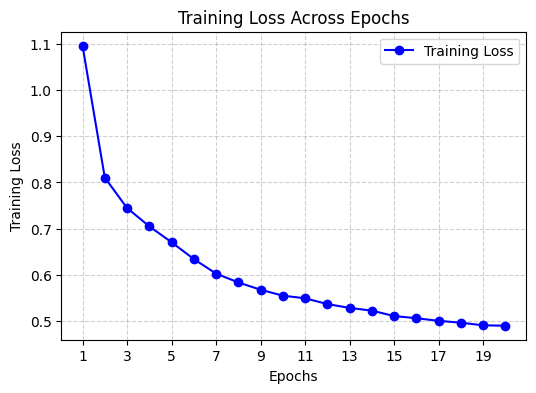

In [32]:
val_loss, val_acc = evaluate_model(model_4, criterion, device, validation_loader)
plot_loss(epoch_losses)

### **3- Third Hyperparameters Combination (lr = 0.001, number of epochs = 30)**

In [33]:
model_4 = SimpleNN(input_size=image_shape, n_class=n_classes, n_layers=10, hidden_units=10, activation='relu')
epoch_losses = train_model(model_4, criterion, device, train_dataloader=training_loader, lr=0.001, n_epochs=30)

Epoch 1/30 finished with loss of 1.028585280418396
Epoch 2/30 finished with loss of 0.6420852043867111
Epoch 3/30 finished with loss of 0.5884694226582845
Epoch 4/30 finished with loss of 0.5545995334625244
Epoch 5/30 finished with loss of 0.5291228312492371
Epoch 6/30 finished with loss of 0.5148244599024455
Epoch 7/30 finished with loss of 0.5018837761839231
Epoch 8/30 finished with loss of 0.49466747947533923
Epoch 9/30 finished with loss of 0.48898932249943416
Epoch 10/30 finished with loss of 0.4778660502791405
Epoch 11/30 finished with loss of 0.471274478216966
Epoch 12/30 finished with loss of 0.46716570297082266
Epoch 13/30 finished with loss of 0.45967104398409525
Epoch 14/30 finished with loss of 0.45394773396253585
Epoch 15/30 finished with loss of 0.44996585150162377
Epoch 16/30 finished with loss of 0.44761440291404725
Epoch 17/30 finished with loss of 0.44407445915142696
Epoch 18/30 finished with loss of 0.4406275197664897
Epoch 19/30 finished with loss of 0.4395412139097

Validation Loss: 0.0037867797046899796
Validation Accuracy: 82.89999999999999 %


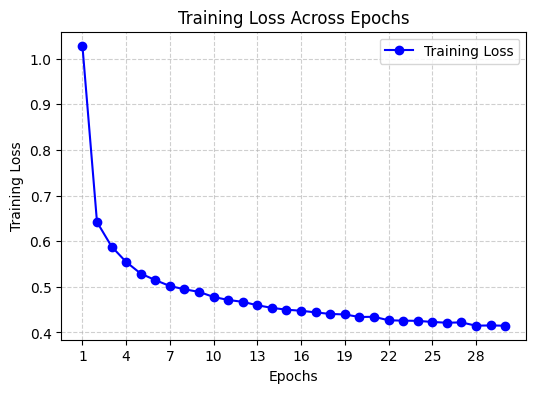

In [34]:
val_loss, val_acc = evaluate_model(model_4, criterion, device, validation_loader)
plot_loss(epoch_losses)